In [2]:
from xai.policy import *
from xai.buffer import Buffer
from xai.bytes import GigaBytes
from numpy import uint8
from numpy.typing import NDArray
import matplotlib.pyplot as plt

import mnist
import torch
import random
import shap
import numpy as np

In [5]:
latent_dim = 5

In [3]:
scale = 7
images = mnist.train_images()

def upscale_image() -> Iterator[Tensor]:
    image: NDArray[uint8]
    for image in images:
        yield torch.from_numpy(image.repeat(scale,0).repeat(scale,1)).float() / 255.0

big_images = Buffer(
    entries=upscale_image(), 
    eviction_policy="FIFO", 
    use_ram=False, 
    max_memory=GigaBytes(10), 
    verbose=True
    )

labels = torch.from_numpy(mnist.train_labels())
labels_one_hot = torch.zeros((labels.shape[0],10)).float()
labels_one_hot[torch.arange(0,labels.shape[0]),labels.int()] = 1.0

big_images, big_images[0].shape

Disk used: 9.24/10.00GB: : 60000it [01:29, 671.36it/s]


(Buffer(use_ram=False, entries=60000, size=9243.90MB, capacity=92.44%),
 torch.Size([196, 196]))

In [6]:
hidden_dims = [2**8,2**6,2**5]
big_encoder = Policy.new((28*scale,28*scale),latent_dim, hidden_layers=hidden_dims)
big_decoder = Policy.new(latent_dim,(28*scale,28*scale), hidden_layers=hidden_dims[::-1])
big_autoencoder = big_encoder + big_decoder
big_autoencoder

CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)


Sequential(
  (0): Linear(in_features=38416, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=5, bias=True)
  (7): Linear(in_features=5, out_features=32, bias=True)
  (8): ReLU()
  (9): Linear(in_features=32, out_features=64, bias=True)
  (10): ReLU()
  (11): Linear(in_features=64, out_features=256, bias=True)
  (12): ReLU()
  (13): Linear(in_features=256, out_features=38416, bias=True)
)

In [7]:
stats = big_autoencoder.adam().fit(
    X=big_images,
    Y=big_images,
    epochs=750,
    batch_size=64,
    loss_criterion="MSELoss",
    verbose=True,
    info="Big autoencoder train test"
)
stats[5:].plot_loss()

Loss: 0.033435: 100%|██████████| 750/750 [02:42<00:00,  4.61it/s]


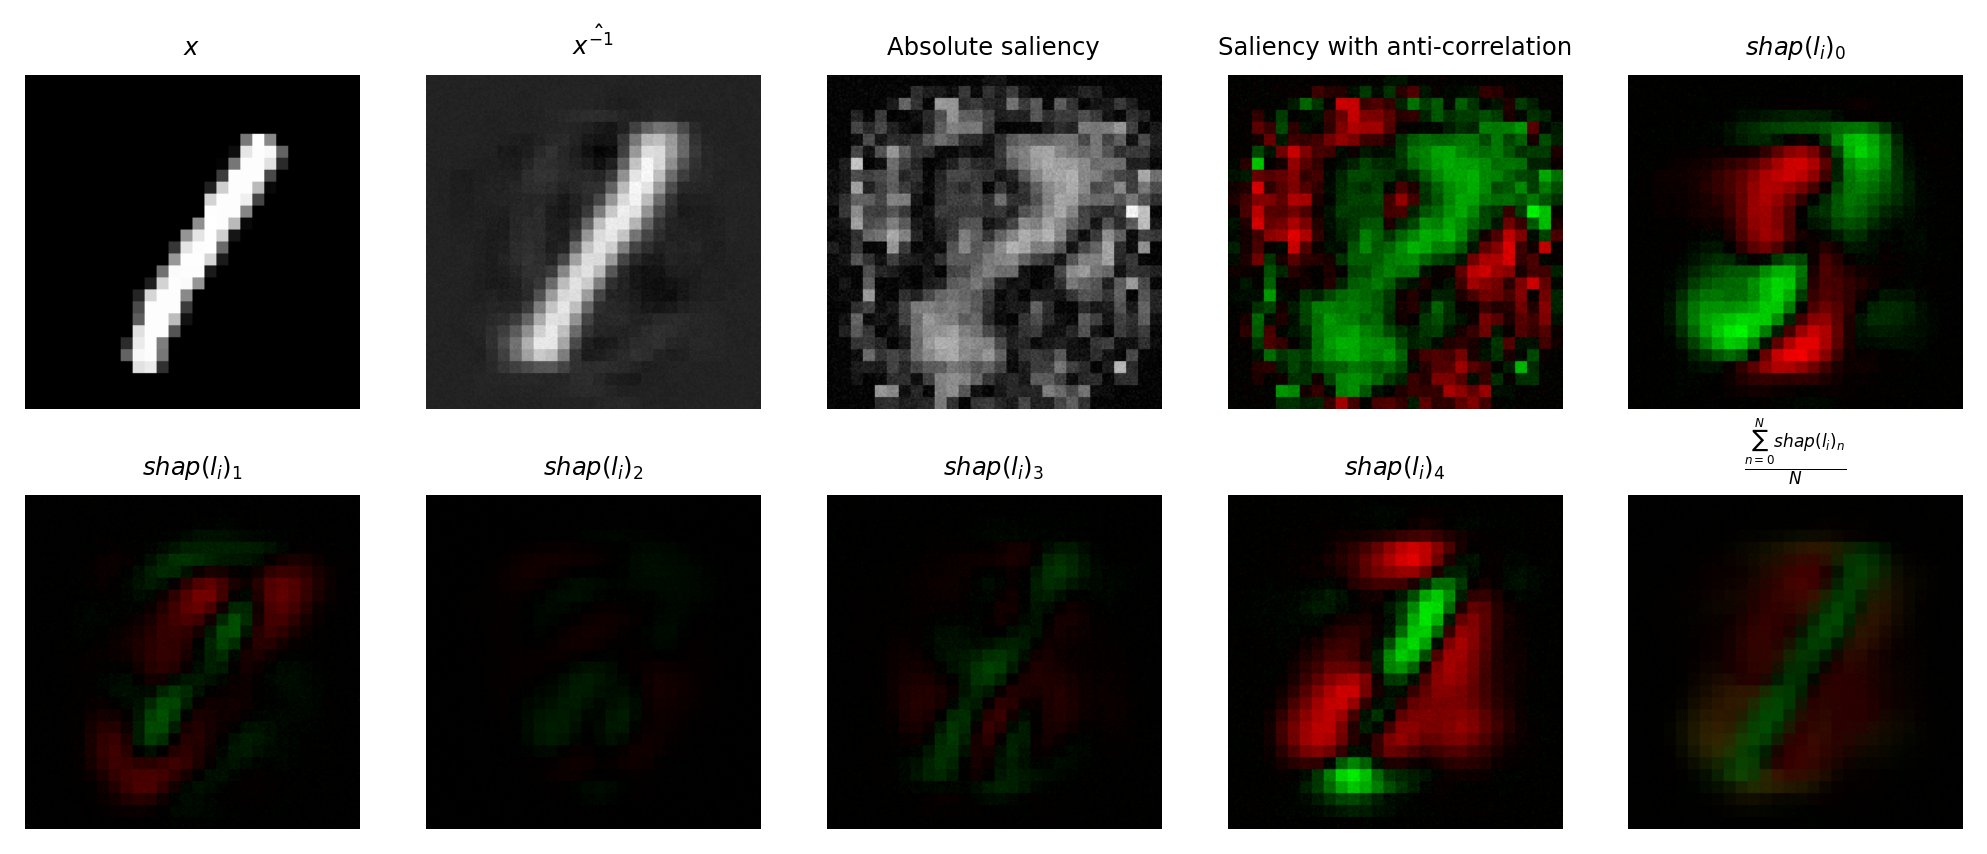

In [58]:
idx = random.randint(0,100)
X = big_images[idx]
X_inv = big_autoencoder(X)
digit = X_inv.tensor().argmax().item()

fig = plt.figure(dpi=250, figsize=(10,4)) 
fig.add_subplot(2,5,1)
plt.imshow(X, cmap="gray") 
plt.axis('off')
plt.title(f'$x$', size=7)

fig.add_subplot(2,5, 2)
plt.imshow(X_inv.numpy(), cmap="gray") 
plt.axis('off')
plt.title(f'$\\hat{{x^{{-1}}}}$', size=7)

abs_saliency = X_inv.saliency(lambda t: t.sum())

fig.add_subplot(2,5,3)
plt.imshow(abs_saliency, cmap="gray") 
plt.axis('off')
plt.title(f"Absolute saliency", size=7)

gradients = X_inv.gradients(lambda t: t.sum())
min,max = gradients.min(), gradients.max()
red = torch.where(gradients < 0, gradients/min, torch.zeros_like(gradients))
green = torch.where(gradients > 0, gradients/max, torch.zeros_like(gradients))
saliency_with_corr = torch.zeros((196,196,3), dtype=torch.float32, device="cpu")
saliency_with_corr[:,:,0] = red
saliency_with_corr[:,:,1] = green

fig.add_subplot(2,5,4)
plt.imshow(saliency_with_corr, cmap="gray") 
plt.axis('off')
plt.title(f"Saliency with anti-correlation", size=7)

data = big_encoder(torch.stack(big_images[:100])).numpy()
explainer = shap.PermutationExplainer(lambda t: big_decoder(torch.from_numpy(t)).numpy().reshape((-1,196*196)), masker=data)
shap_values: shap.Explanation = explainer(data[idx:idx+1], max_evals=11)[0]
shap_values = np.array(shap_values.values).reshape((latent_dim,196,196))

min,max = shap_values.min(), shap_values.max()
red = np.where(shap_values < 0, shap_values/min, np.zeros_like(shap_values))
green = np.where(shap_values > 0, shap_values/max, np.zeros_like(shap_values))

shap_images = []
for i in range(5):
    image = np.zeros((196,196,3), dtype=np.float32)
    image[:,:,0] = red[i]
    image[:,:,1] = green[i]
    shap_images.append(image)
    fig.add_subplot(2,5,i+5)
    plt.imshow(shap_images[-1], cmap="gray")
    plt.axis('off')
    plt.title(f'$shap(l_{{i}})_{i}$', size=7)

fig.add_subplot(2,5,10)
plt.imshow(np.stack(shap_images).mean(axis=0))
plt.axis('off')
plt.title(f'$\\frac{{\sum_{{n=0}}^{{N}}{{shap(l_{{i}})_{{n}}}}}}{{N}}$', size=7)
plt.show()

PermutationExplainer explainer: 2it [00:11, 11.37s/it]               


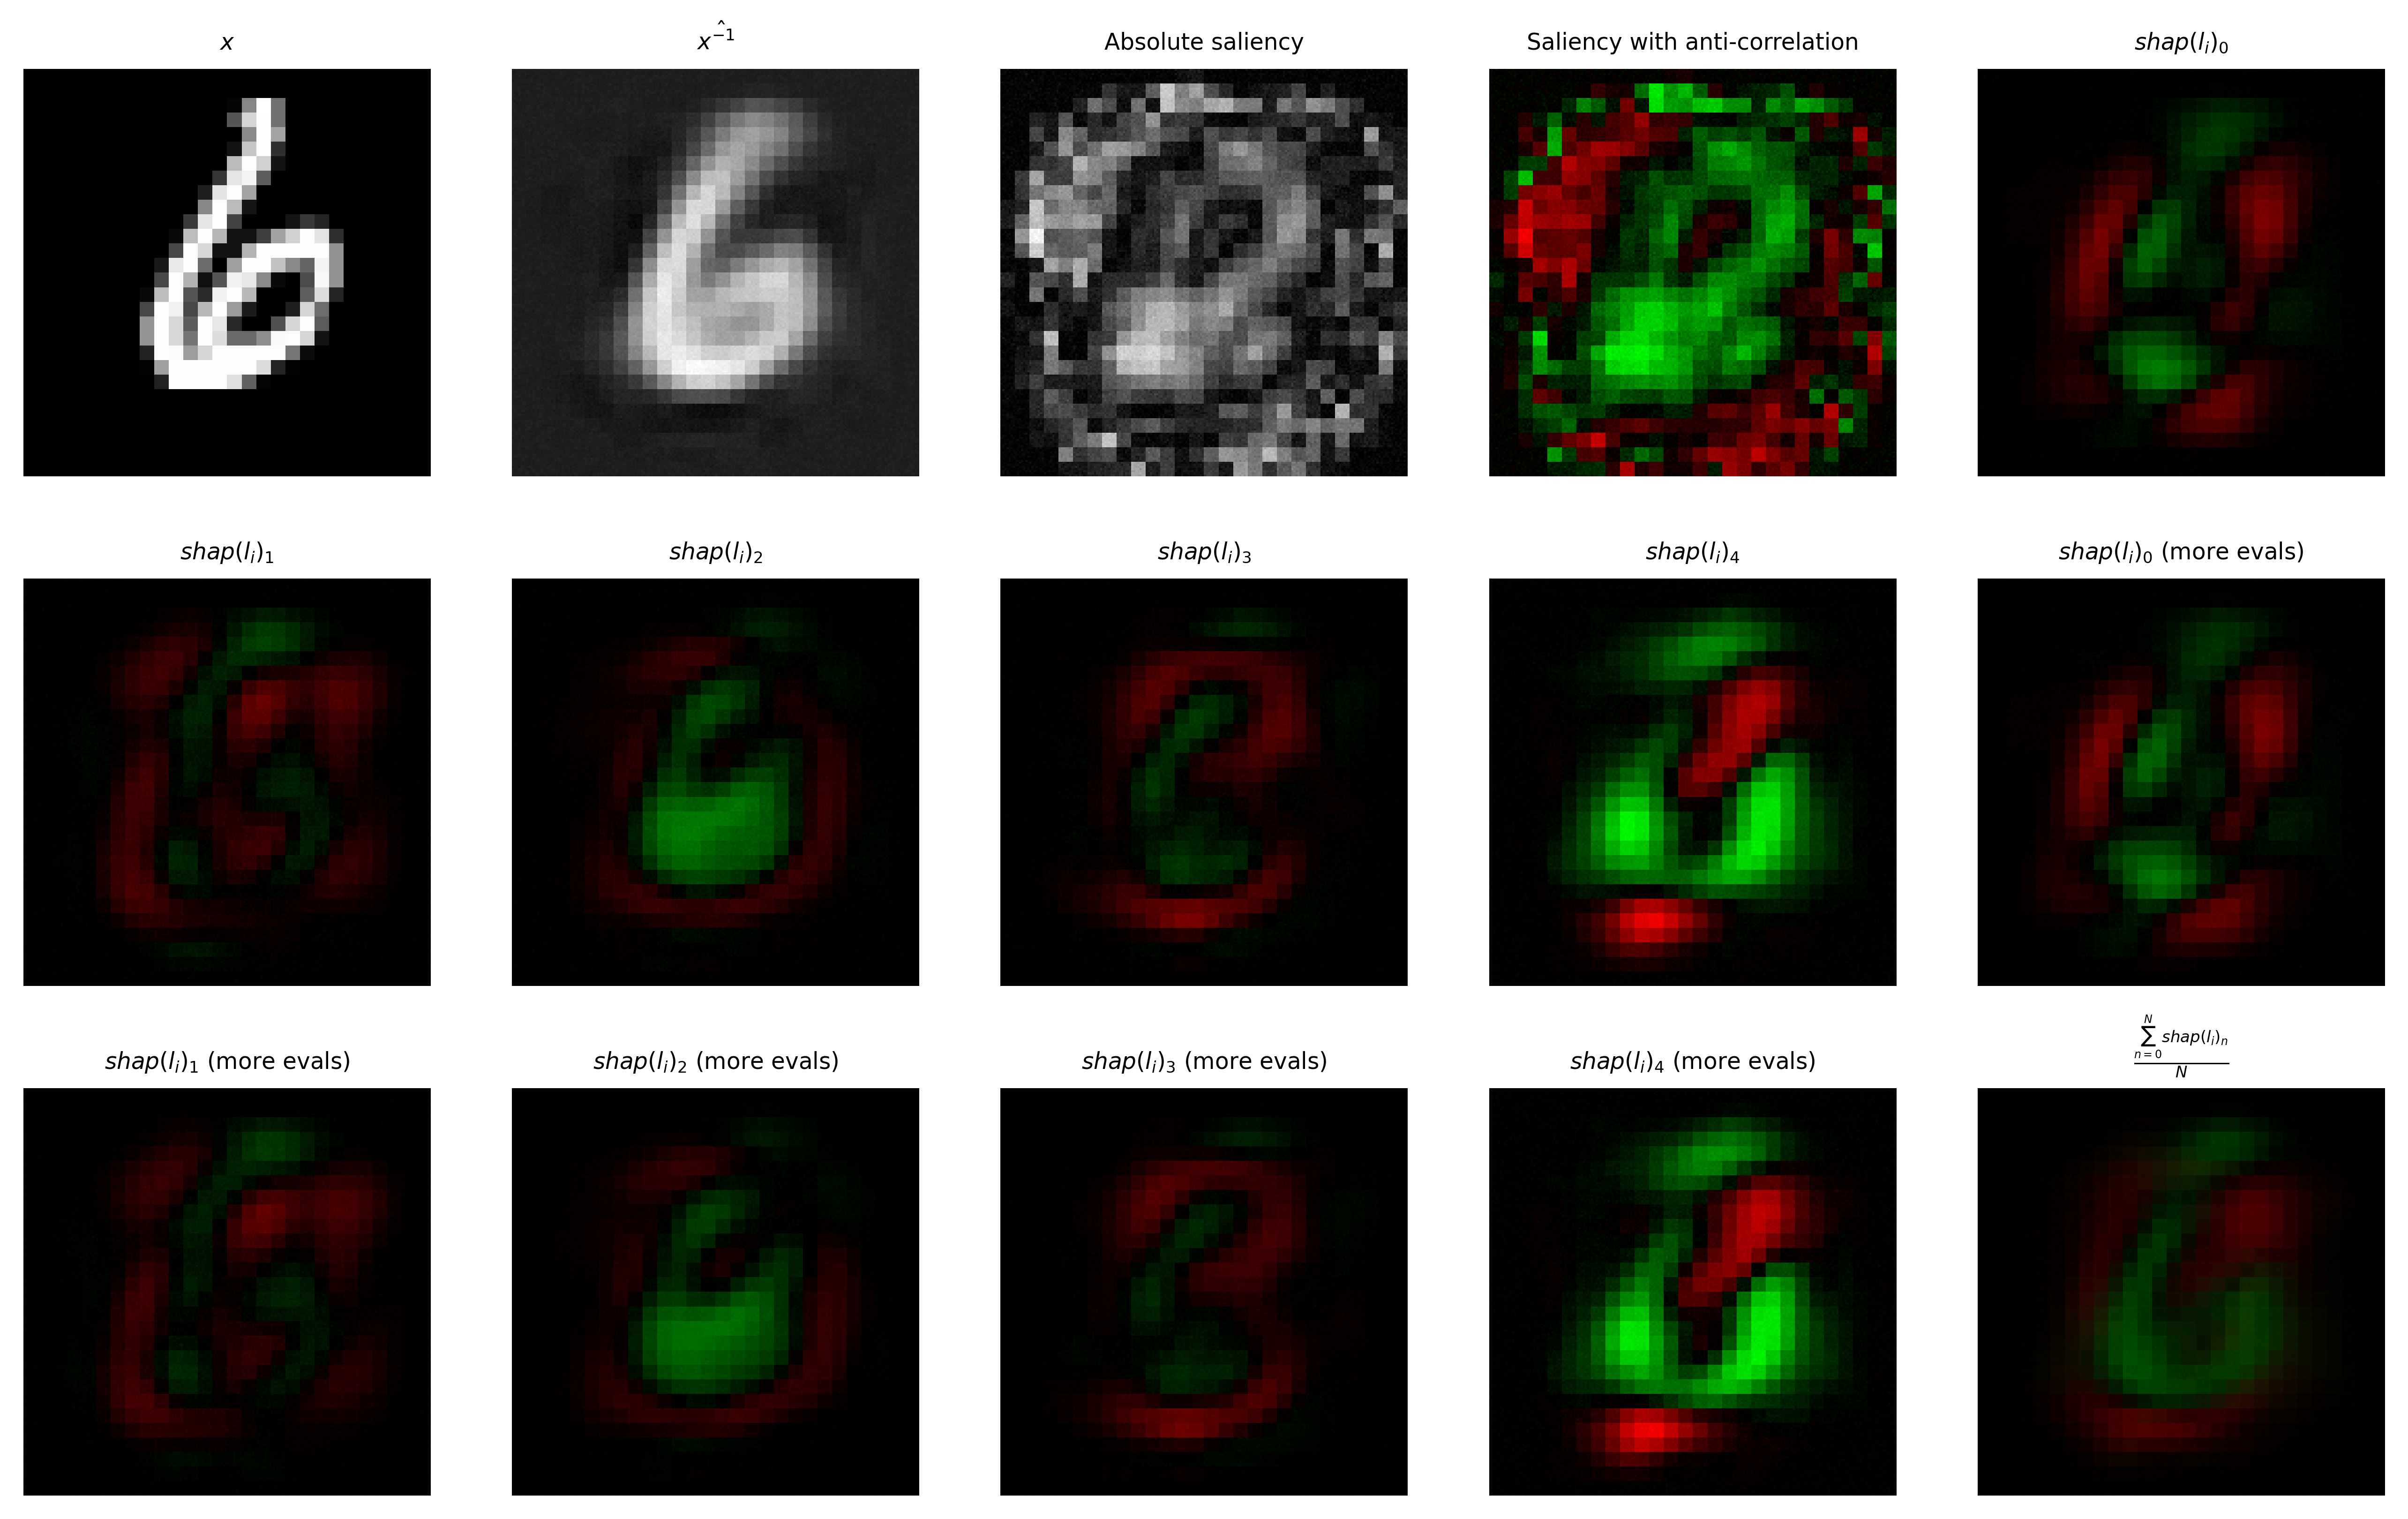

In [61]:
idx = random.randint(0,100)
X = big_images[idx]
X_inv = big_autoencoder(X)
digit = X_inv.tensor().argmax().item()

fig = plt.figure(dpi=500, figsize=(13,8)) 
fig.add_subplot(3,5,1)
plt.imshow(X, cmap="gray") 
plt.axis('off')
plt.title(f'$x$', size=7)

fig.add_subplot(3,5, 2)
plt.imshow(X_inv.numpy(), cmap="gray") 
plt.axis('off')
plt.title(f'$\\hat{{x^{{-1}}}}$', size=7)

abs_saliency = X_inv.saliency(lambda t: t.sum())

fig.add_subplot(3,5,3)
plt.imshow(abs_saliency, cmap="gray") 
plt.axis('off')
plt.title(f"Absolute saliency", size=7)

gradients = X_inv.gradients(lambda t: t.sum())
min,max = gradients.min(), gradients.max()
red = torch.where(gradients < 0, gradients/min, torch.zeros_like(gradients))
green = torch.where(gradients > 0, gradients/max, torch.zeros_like(gradients))
saliency_with_corr = torch.zeros((196,196,3), dtype=torch.float32, device="cpu")
saliency_with_corr[:,:,0] = red
saliency_with_corr[:,:,1] = green

fig.add_subplot(3,5,4)
plt.imshow(saliency_with_corr, cmap="gray") 
plt.axis('off')
plt.title(f"Saliency with anti-correlation", size=7)

data = big_encoder(torch.stack(big_images[:100])).numpy()
explainer = shap.PermutationExplainer(lambda t: big_decoder(torch.from_numpy(t)).numpy().reshape((-1,196*196)), masker=data)
shap_values: shap.Explanation = explainer(data[idx:idx+1], max_evals=11)[0]
shap_values = np.array(shap_values.values).reshape((latent_dim,196,196))

min,max = shap_values.min(), shap_values.max()
red = np.where(shap_values < 0, shap_values/min, np.zeros_like(shap_values))
green = np.where(shap_values > 0, shap_values/max, np.zeros_like(shap_values))

shap_images = []
for i in range(5):
    image = np.zeros((196,196,3), dtype=np.float32)
    image[:,:,0] = red[i]
    image[:,:,1] = green[i]
    shap_images.append(image)
    fig.add_subplot(3,5,i+5)
    plt.imshow(shap_images[-1], cmap="gray")
    plt.axis('off')
    plt.title(f'$shap(l_{{i}})_{i}$', size=7)

data = big_encoder(torch.stack(big_images[:100])).numpy()
explainer = shap.PermutationExplainer(lambda t: big_decoder(torch.from_numpy(t)).numpy().reshape((-1,196*196)), masker=data)
shap_values: shap.Explanation = explainer(data[idx:idx+1], max_evals=500)[0]
shap_values = np.array(shap_values.values).reshape((latent_dim,196,196))

min,max = shap_values.min(), shap_values.max()
red = np.where(shap_values < 0, shap_values/min, np.zeros_like(shap_values))
green = np.where(shap_values > 0, shap_values/max, np.zeros_like(shap_values))

shap_images = []
for i in range(5):
    image = np.zeros((196,196,3), dtype=np.float32)
    image[:,:,0] = red[i]
    image[:,:,1] = green[i]
    shap_images.append(image)
    fig.add_subplot(3,5,i+10)
    plt.imshow(shap_images[-1], cmap="gray")
    plt.axis('off')
    plt.title(f'$shap(l_{{i}})_{i}$ (more evals)', size=7)

fig.add_subplot(3,5,15)
plt.imshow(np.stack(shap_images).mean(axis=0))
plt.axis('off')
plt.title(f'$\\frac{{\sum_{{n=0}}^{{N}}{{shap(l_{{i}})_{{n}}}}}}{{N}}$', size=7)
plt.show()